# A whole implementation cycle

In [94]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.io import decode_image

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [137]:
# Tensoren



In [ ]:
training_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

#map-style datasets can be indexable

#transforms can be different, e.g.
ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
)
#one-hot-encoding???, verstehe ich noch nicht so ganz


In [ ]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

test_dataloader2 = DataLoader(test_data, batch_size=batch_size, shuffle=True)

#batch_size == 1 (default)
#es gibt auch noch collate_fn (collation function), sampler, batch_sampler, drop_last

for (X, y) in test_dataloader:
    print(f"Form von X [N, C, H, W]: {X.shape}") #Wieso Shape (64, 1, 28, 28) und nicht (64, 28, 28) (die 3. Dimension ist die Anzahl an Channels, richtig?)
    print(f"Form von y: {y.shape} {y.dtype}")
    break

for batch, (X, y) in enumerate(test_dataloader2):
    print(batch)
    print(f"Form von X [N, C, H, W]: {X.shape}")
    print(f"Form von y: {y.shape} {y.dtype}")
    break

(train_features, train_labels) = next(iter(test_dataloader2)) #sind beide indizierbar!
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


Form von X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Form von y: torch.Size([64]) torch.int64
0
Form von X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Form von y: torch.Size([64]) torch.int64
Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


In [27]:
#device = torch.accelerator.current_accelerator().type if torch.accelerator.is_avalaible() else "cpu"
#print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self): # Why this architecture?
        super().__init__()

        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x): #What is x??
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
#model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [28]:
loss_fn = nn.CrossEntropyLoss() #What does fn stand for??
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [29]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        #X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss = loss.item()
            current = (batch + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [30]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for (X, y) in dataloader:
            #X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Testfehler: \n Genauigkeit: {(100*correct):>0.1f}%, Durchschnitt Loss: {test_loss:>8f} \n")

In [31]:
epochs = 5
for t in range(epochs):
    print(f"Epoche {t}\n---------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Fertig!")

Epoche 0
---------------------
loss: 2.300394 [   64/60000]
loss: 2.284032 [ 6464/60000]
loss: 2.268046 [12864/60000]
loss: 2.270931 [19264/60000]
loss: 2.236773 [25664/60000]
loss: 2.208220 [32064/60000]
loss: 2.228182 [38464/60000]
loss: 2.183875 [44864/60000]
loss: 2.184040 [51264/60000]
loss: 2.153859 [57664/60000]
Testfehler: 
 Genauigkeit: 39.5%, Durchschnitt Loss: 2.142764 

Epoche 1
---------------------
loss: 2.152645 [   64/60000]
loss: 2.135967 [ 6464/60000]
loss: 2.078264 [12864/60000]
loss: 2.101962 [19264/60000]
loss: 2.035828 [25664/60000]
loss: 1.973403 [32064/60000]
loss: 2.013395 [38464/60000]
loss: 1.921902 [44864/60000]
loss: 1.935038 [51264/60000]
loss: 1.858460 [57664/60000]
Testfehler: 
 Genauigkeit: 57.2%, Durchschnitt Loss: 1.856292 

Epoche 2
---------------------
loss: 1.888008 [   64/60000]
loss: 1.851641 [ 6464/60000]
loss: 1.732595 [12864/60000]
loss: 1.783611 [19264/60000]
loss: 1.665695 [25664/60000]
loss: 1.620160 [32064/60000]
loss: 1.651404 [38464/600

In [32]:
torch.save(model.state_dict(), "model.pth") # Was ist ne .pth-Datei?
print("PyTorch Modellzustand zu model.pth gespeichert.")

PyTorch Modellzustand zu model.pth gespeichert.


In [33]:
model= NeuralNetwork()
model.load_state_dict(torch.load("model.pth", weights_only=True))

/home/AD.IGD.FRAUNHOFER.DE/fri50232/Dokumente/local_workspace/d2l-en/.venv/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


<All keys matched successfully>

In [34]:
classes = [
    "T-shirt/Oberteil",
    "Hose",
    "Pullover",
    "Kleid",
    "Mantel",
    "Sandalen",
    "Shirt",
    "Sneakers",
    "Tasche",
    "Stiefeletten",
]

In [35]:
model.eval()
x = test_data[0][0]
y = test_data[0][1]

with torch.no_grad():
    #x = x.to(device)
    pred = model(x)
    predicted = classes[pred[0].argmax(0)]
    actual = classes[y]
    print(f'Vorhergesagt: "{predicted}", Tatsächliche Klasse: "{actual}"')

Vorhergesagt: "Stiefeletten", Tatsächliche Klasse: "Stiefeletten"


(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000

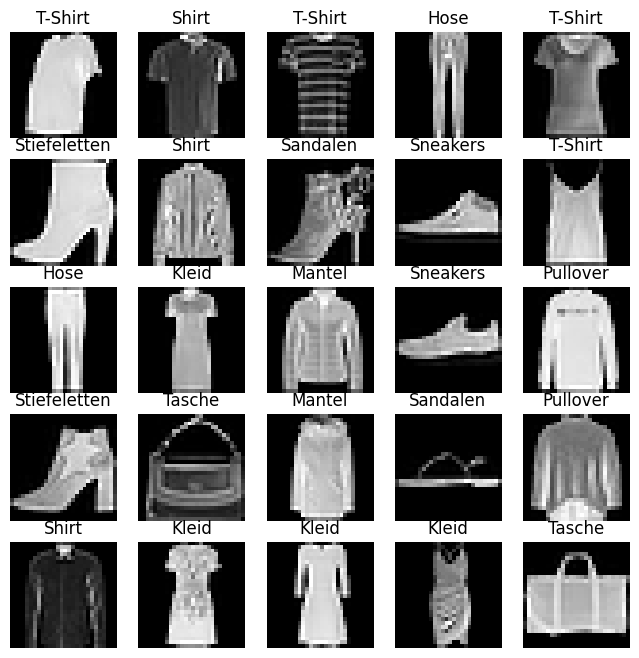

In [54]:
import matplotlib.pyplot as plt

#Klassen-Labels für FashionMNIST
labels_map = {
    0: "T-Shirt",
    1: "Hose",
    2: "Pullover",
    3: "Kleid",
    4: "Mantel",
    5: "Sandalen",
    6: "Shirt",
    7: "Sneakers",
    8: "Tasche",
    9: "Stiefeletten"
}

figure = plt.figure(figsize=(8,8))
cols = rows = 5
training_data = datasets.FashionMNIST(root="data", download=True, transform=transforms.ToTensor())
print(training_data[0])

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    (img, label) = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1,2,0), cmap="gray") #img.squeeze possible, when C=1
    # many constructors from torchvision.datasets get us images in the format (C, H, W); matplotlib expects (H, W, C)!!
plt.show()


In [39]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[index, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[index, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return (image, label)

#customDataset = CustomImageDataset(annotations_file="FashionMNIST_anotations.csv", img_dir="data/FashionMNIST", transform=ToTensor())